In [48]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [49]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

print(tf.__version__)  # Harusnya muncul 2.19.0


2.19.0


In [50]:
df = pd.read_csv('data_berat_intensitas.csv', sep=';')
df_200 = df.head(200)
print(df_200.head())
# print(df.head(5))

   berat intensitas
0  70,38     590,21
1  60,85     436,37
2  59,44     551,53
3   55,7     507,68
4  58,59     600,98


In [51]:
#cleaning data koma ke titik
df['berat'] = df['berat'].str.replace(',', '.', regex=False).astype(float)
df['intensitas'] = df['intensitas'].str.replace(',', '.', regex=False).astype(float)
print(df.head())

   berat  intensitas
0  70.38      590.21
1  60.85      436.37
2  59.44      551.53
3  55.70      507.68
4  58.59      600.98


In [52]:
#scaling normalisasi
from sklearn.preprocessing import MinMaxScaler
X = df[['berat', 'intensitas']]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [53]:
input_dim = X_scaled.shape[1]
encoding_dim = 2  # 2 dimensi untuk visualisasi

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

optimizer = Adam(learning_rate=0.005)
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=4, verbose=0)

In [54]:
X_latent = encoder.predict(X_scaled)

#k-mens clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_latent)
print("Autoencoder input shape:", autoencoder.input_shape)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Autoencoder input shape: (None, 2)


d:\Document\Sains Data\S6\0.1. Capstone_Project\Project\deep_learning\venv\Lib\site-packages\sklearn\base.py:1363: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [55]:
df['klaster_deep'] = labels
print("\nDataframe dengan Klaster:")
print(df.head(15))


Dataframe dengan Klaster:
    berat  intensitas  klaster_deep
0   70.38      590.21             0
1   60.85      436.37             0
2   59.44      551.53             0
3   55.70      507.68             0
4   58.59      600.98             0
5   61.97      507.59             0
6   48.56      671.02             0
7   66.77      364.15             0
8   51.80      394.50             0
9   52.05      350.30             0
10  63.93      650.90             0
11  54.10      358.18             0
12  57.71      427.59             0
13  59.31      652.11             0
14  57.89      631.67             0


In [56]:
print("Jumlah klaster KMeans:", len(set(kmeans.labels_)))

Jumlah klaster KMeans: 1


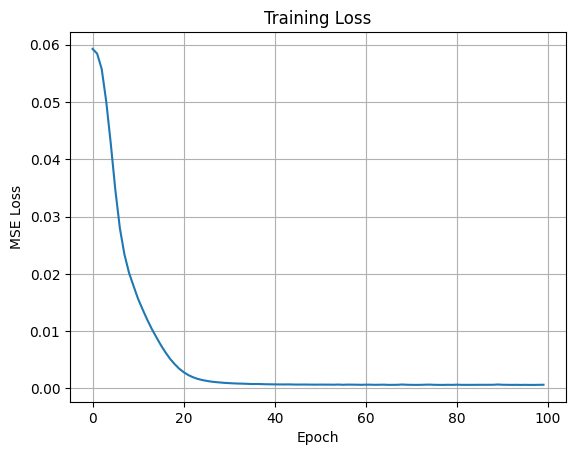

In [36]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid()
plt.show()


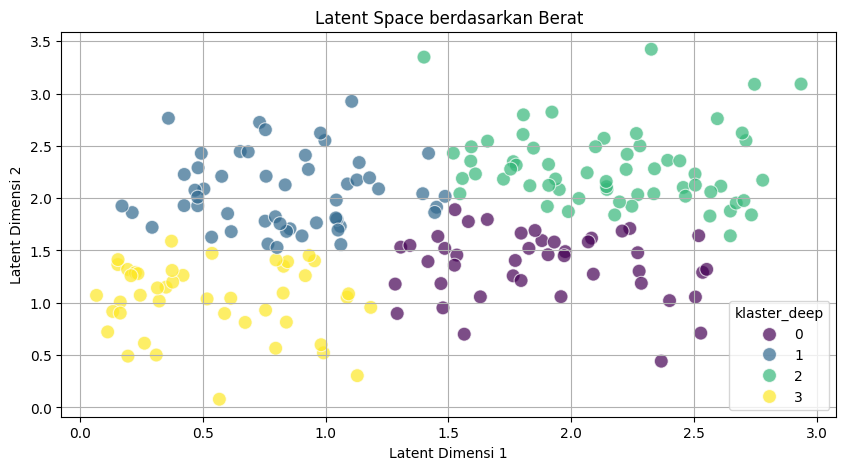

In [37]:
#visualisasi latent space
plt.figure(figsize=(10,5))
sns.scatterplot(x=X_latent[:,0], y=X_latent[:,1], hue=df['klaster_deep'], palette='viridis', s=100, alpha=0.7)
plt.title('Latent Space berdasarkan Berat')
plt.xlabel('Latent Dimensi 1')
plt.ylabel('Latent Dimensi 2')
plt.grid(True)
plt.show()

In [38]:
#cek matrik evaluasi
score = silhouette_score(X_latent, labels) #mengukur kualitas clustering
print("Silhouette Score:", score) # yaitu seberapa baik setiap titik data
# berada di dalam klusternya dibandingkan dengan kluster lain.
# === Semakin tinggi nilainya semakin bagus klustering ===

X_reconstructed = autoencoder.predict(X_scaled)
mse = mean_squared_error(X_scaled, X_reconstructed)
print("Reconstruction MSE:", mse) #seberapa jauh hasil rekonstruksi autoencoder dibanding data input aslinya
# === Semakin mendekati 0, semakin bagus ===

Silhouette Score: 0.3854687213897705
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Reconstruction MSE: 0.000637094339105169


In [39]:
#mencari jumlah klaster terbaik
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels_k = kmeans.fit_predict(X_latent)
    score_k = silhouette_score(X_latent, labels_k)
    scores.append((k, score_k))
    print(f"K={k}, Silhouette Score={score_k:.4f}")

K=2, Silhouette Score=0.4466
K=3, Silhouette Score=0.3648
K=4, Silhouette Score=0.3855
K=5, Silhouette Score=0.3514
K=6, Silhouette Score=0.3534
K=7, Silhouette Score=0.3476
K=8, Silhouette Score=0.3564
K=9, Silhouette Score=0.3554


In [40]:
#grup statistik berat/intensitas
print(df.groupby('klaster_deep')['berat',].describe())

             berat                                                           
             count       mean       std    min     25%    50%      75%    max
klaster_deep                                                                 
0             43.0  52.522558  3.044193  43.39  50.885  53.16  54.6200  57.89
1             52.0  60.588654  3.175141  55.67  57.890  60.16  62.6650  67.95
2             61.0  60.431475  3.421411  53.73  58.000  60.16  62.3500  71.27
3             44.0  51.816136  3.221135  43.16  49.965  52.14  54.4775  57.13


In [41]:
print(df.groupby('klaster_deep')['intensitas'].describe())

              count        mean        std     min       25%      50%  \
klaster_deep                                                            
0              43.0  581.062558  62.268891  487.29  525.3900  572.120   
1              52.0  398.765000  51.756451  300.69  358.8025  403.940   
2              61.0  598.654918  62.406513  449.50  545.1000  600.980   
3              44.0  383.649318  54.392153  309.32  334.9300  366.845   

                  75%     max  
klaster_deep                   
0             624.090  699.60  
1             437.965  501.16  
2             652.110  698.86  
3             427.510  495.40  


In [42]:
autoencoder.summary()
for i, layer in enumerate(autoencoder.layers):
    print(i, layer.name)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 494 (1.93 KB)

 Trainable params: 164 (656.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 330 (1.29 KB)

0 input_layer_1
1 dense_4
2 dense_5
3 dense_6
4 dense_7


Text(0.5, 1.0, 'Clustering Berdasarkan Latent Space + Intensitas')

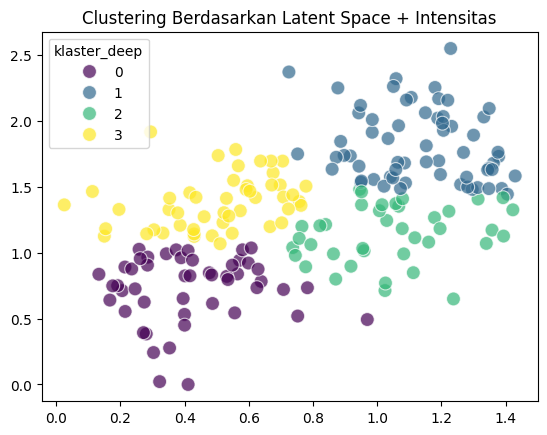

In [21]:
sns.scatterplot(x=X_latent[:,0], y=X_latent[:,1], hue=df['klaster_deep'], palette='viridis', s=100, alpha=0.7)
plt.title('Clustering Berdasarkan Latent Space + Intensitas')

In [71]:
import os

if not os.path.exists('model'):
    os.makedirs('model')

In [45]:
# Misal model = tf.keras.models.Model(...)
autoencoder.save('model/autoencoder_berat_x.keras')


In [46]:
import joblib
joblib.dump(kmeans, 'model/kmeans_berat_x.pkl')


['model/kmeans_berat_x.pkl']